<a href="https://colab.research.google.com/github/polinamaximenko/compling/blob/main/SMT_PM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```Курс "Компьютерная лингвистика" | НИУ ВШЭ Санкт-Петербург
2024 (c) В.И. Фирсанова```

# Tiny SMT

*Обзор*

**Введение (20 минут)**

1. **Компоненты SMT (15 минут)**
   - Определение SMT
   - Компоненты: параллельные корпуса, выравнивание, языковая модель, модель перевода, декодер

2. **Загрузка библиотек (5 минут)**
   - Библиотеки для обработки текстов: NLTK, Spacy
   - Библиотеки для машинного обучения: Scikit-learn

**Tiny SMT (60 минут)**

**1: Препроцессинг (15 минут)**

1. **Паралелльные корпуса (5 минут)**
   - Полезные ресурсы
   - Загрузка датасета EN-DE

2. **Подготовка данных (10 минут)**
   - Чистка данных
   - Токенизация

**2: Модель SMT (20 минут)**

1. **IBM 1 EM (10 минут)**
   - Алгоритм Expectation-Maximization
   - Пишем t-модель с нуля!

2. **LM (10 минут)**
   - Биграммная языковая модель
   - Пишем крошечную LM

**3: Оценка результатов (10 минут)**

1. **BLEU Score (5 минут)**
   - Как считать BLEU
   - Оцениваем нашу модель

2. **Интерпретация результатов (5 минут)**
   - Генерация примеров
   - Интерпретация!

**Домашнее задание:**

- Обучить модель на корпусе EN-RU

# Введение

## Компоненты SMT

**Формальное определение SMT (как это считать --> математика):**
- дано предложение на языке X,
- найти наиболее правдоподобный перевод этого предложения на язык Y (допускаем, что переводом исходного предложения может быть любое предложение на целевом языке):
  - найти такое предложение, которое максимизирует `P(y|x)`, т.е. `argmax P(y|x)`:
    - вычислить допустимые варианты предложений на языке Y путем создания языковой модели `P(y)`;
    - вычислить допустимые пары X - Y путем сопоставления статистических совпадений выравненных фраз в параллельном корпусе `P(x|y)`;
    - максимизировать результат вычисления `P(y) P(x|y)`, т.е. `argmax P(y) P(x|y)`
**Компоненты модели SMT (как это программировать --> код):**

1. ***N-граммная языковая модель*** - моделируем *вероятностное распределение* конструкций на уровне слов или фраз в языке Y
2. ***Модель перевода (t-model)*** - собираем *статистику* соотвествий фраз в паралелльном корпусе, ищем переводческие соответствия X - Y и моделируем их с помощью теории *вероятности*:
  1. Допускаем, что любое предложение языка Y может быть "искаженной", "зашумленной" версией некой фразы на языке X
  2. Ищем наиболее правдоподобные соответствия X - Y (таблица с соответствиями и вероятностями = t-table)
3. ***Декодер*** - ищем наиболее грамматичные и лексически правдоподобные результаты, отбираем среди *гипотез* один результат

## Загрузка библиотек

Ваши друзья:

[`sklearn`](https://scikit-learn.org/stable/)

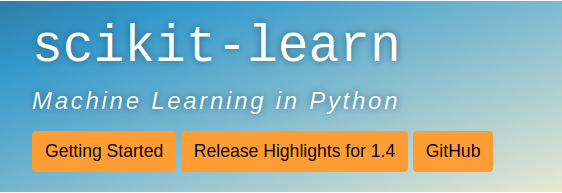

In [ ]:
import tarfile # для распаковски архивов

from sklearn.model_selection import train_test_split # разделение на выборки

from collections import Counter, defaultdict # для представления t-table в виде словаря
import random # используем рандомный генератор для работы языковой модели (случайное число = исходная точка)

# *Tiny* SMT

## 1: Препроцессинг

### Параллельные корпуса

[OPUS](https://opus.nlpl.eu/) Corpora

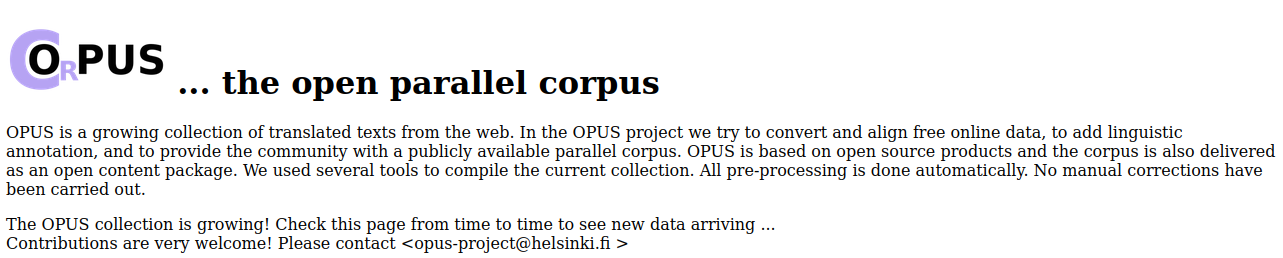

[Kaggle](https://www.kaggle.com/datasets/devicharith/language-translation-englishfrench)

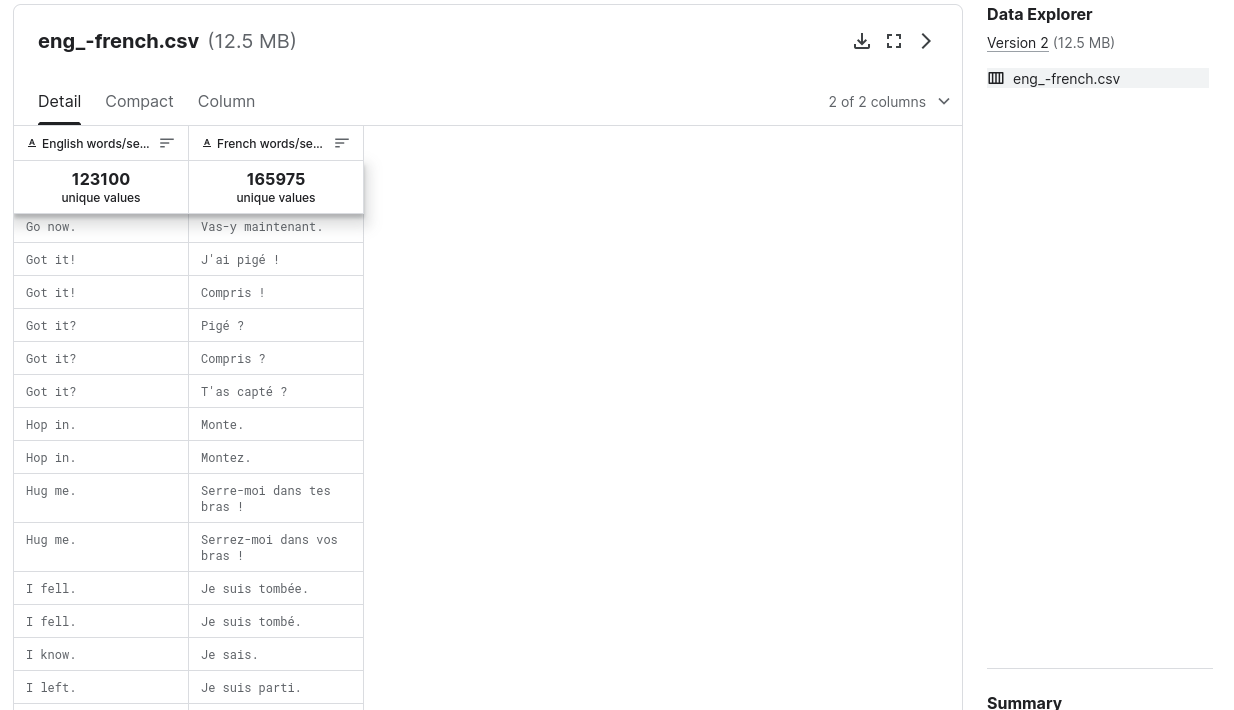

[HuggingFace](https://huggingface.co/datasets?task_categories=task_categories:translation&sort=trending)

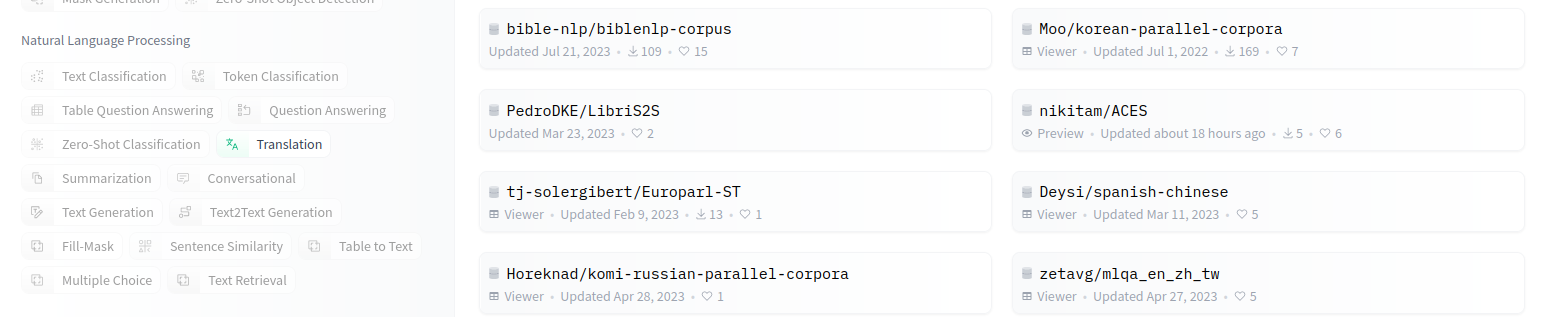

**Задание 1**

Загрузим датасет [Toy 6 short sentences](https://www.cis.lmu.de/~fraser/EMA2008/model1.html)

Для повторения эксперимента я выбрала датасет [German-English 292 short sentences](https://www.cis.lmu.de/~fraser/EMA2008/model1.html)

In [ ]:
# извлекаем файлы из архива
with tarfile.open('de-en.tiny.tgz', 'r:gz') as tar:
  tar.extractall()

Вызовем команду shell `ls`, чтобы увидеть, что мы распаковали.

In [ ]:
!ls

de-en.tiny.de  de-en.tiny.en  de-en.tiny.tgz  sample_data


Создаем 2 выборки и токенизируем тексты по фразам.

In [ ]:
with open('de-en.tiny.de', 'r') as f:
  german = f.read().split('\n')[:-1]

with open('de-en.tiny.en', 'r') as f:
  english = f.read().split('\n')[:-1]

print("Данные языка X:\n", german)
print("Данные языка Y:\n", english)

Данные языка X:
 ['Wiederaufnahme der Sitzungsperiode', 'Ich bitte Sie , sich zu einer Schweigeminute zu erheben .', '( Das Parlament erhebt sich zu einer Schweigeminute . )', 'Frau Präsidentin , zur Geschäftsordnung .', 'Wenn das Haus damit einverstanden ist , werde ich dem Vorschlag von Herrn Evans folgen .', 'Frau Präsidentin , zur Geschäftsordnung .', 'Könnten Sie mir eine Auskunft zu Artikel 143 im Zusammenhang mit der Unzulässigkeit geben ?', 'Und zwar sollen derartige Strafen trotz des Grundsatzes der relativen Stabilität verhängt werden .', 'All dies entspricht den Grundsätzen , die wir stets verteidigt haben .', 'Vielen Dank , Herr Segni , das will ich gerne tun .', 'Das ist ganz im Sinne der Position , die wir als Parlament immer vertreten haben .', 'Das ist der Fall von Alexander Nikitin .', 'Nun ist es aber so , daß er wieder angeklagt werden soll , weil der Staatsanwalt in Berufung geht .', 'Dennoch , Frau Präsidentin , wurde meinem Wunsch nicht entsprochen .', 'Deshalb mö

Разделим нашу выборку с помощью sklearn.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(english, german)

print("> Обучающая выборка:")
for text, label in zip(X_train, y_train):
    print(f"\nТекст на немецком: {label}\n Его перевод на английский: {text}\n")

print("> Тестовая выборка:")
for text, label in zip(X_test, y_test):
    print(f"\nТекст на немецком: {label}\n Его перевод на английский: {text}\n")

> Обучающая выборка:

Текст на немецком: Wir müssen herausfinden , über welche Qualifikationen und Potentiale unsere Regionen im High-Tech-Sektor verfügen .
 Его перевод на английский: It is important to identify the skills and potential of our regions in the hi-tech sector .


Текст на немецком: Darüber hinaus wird auf die Notwendigkeit einer verstärkten Transparenz hingewiesen .
 Его перевод на английский: In addition , the need for greater transparency has been pointed out .


Текст на немецком: Ich möchte zwei davon kurz zusammenfassen , der Berichterstatter hat sie schon aufgegriffen , eine positive und eine negative .
 Его перевод на английский: I shall summarise two of those highlighted by the rapporteur , one positive and one negative .


Текст на немецком: Ein solches Dokument gibt es nicht !
 Его перевод на английский: There is no such document !


Текст на немецком: Ich bitte , diese Entscheidung zu überdenken , weil das nicht der Fall ist .
 Его перевод на английский: I wou

### Подготовка данных

На этом этапе вы можете провести чистку данных, выделить би- или триграммы и т.д. Проведем пословную токенизацию каждой фразы.

In [ ]:
def tokenize(sentences):
  # функция возвращает списки слов
  return [sentence.split() for sentence in sentences]

# токенизируем каждую выборку
X_train_tokens, X_test_tokens, y_train_tokens, y_test_tokens = tokenize(X_train), tokenize(X_test), tokenize(y_train), tokenize(y_test)

print('Образец токенизированного текста:', X_train_tokens)

Образец токенизированного текста: [['It', 'is', 'important', 'to', 'identify', 'the', 'skills', 'and', 'potential', 'of', 'our', 'regions', 'in', 'the', 'hi-tech', 'sector', '.'], ['In', 'addition', ',', 'the', 'need', 'for', 'greater', 'transparency', 'has', 'been', 'pointed', 'out', '.'], ['I', 'shall', 'summarise', 'two', 'of', 'those', 'highlighted', 'by', 'the', 'rapporteur', ',', 'one', 'positive', 'and', 'one', 'negative', '.'], ['There', 'is', 'no', 'such', 'document', '!'], ['I', 'would', 'ask', 'that', 'they', 'reconsider', ',', 'since', 'this', 'is', 'not', 'the', 'case', '.'], ['I', 'think', 'that', 'this', 'work', 'has', 'been', 'carried', 'out', 'extremely', 'well', '.'], ['In', 'order', 'to', 'be', 'effective', ',', 'it', 'must', 'be', 'well', 'anchored', 'in', 'the', 'Member', 'States', "'", 'national', 'authorities', '.'], ['Public', 'monopolies', 'are', ',', 'more', 'often', 'than', 'not', ',', 'phased', 'out', 'reluctantly', '.'], ['The', 'second', 'point', 'relates'

Создадим словарь уникальных словоформ.

In [ ]:
x_vocab = Counter(' '.join(german).split()).keys()
y_vocab = Counter(' '.join(english).split()).keys()

print(f"Словарь немецких словоформ: {x_vocab}\n Всего {len(x_vocab)} словоформ")
print(f"\nCловарь английских словоформ: {y_vocab}\n Всего {len(y_vocab)} словоформ")

Словарь немецких словоформ: dict_keys(['Wiederaufnahme', 'der', 'Sitzungsperiode', 'Ich', 'bitte', 'Sie', ',', 'sich', 'zu', 'einer', 'Schweigeminute', 'erheben', '.', '(', 'Das', 'Parlament', 'erhebt', ')', 'Frau', 'Präsidentin', 'zur', 'Geschäftsordnung', 'Wenn', 'das', 'Haus', 'damit', 'einverstanden', 'ist', 'werde', 'ich', 'dem', 'Vorschlag', 'von', 'Herrn', 'Evans', 'folgen', 'Könnten', 'mir', 'eine', 'Auskunft', 'Artikel', '143', 'im', 'Zusammenhang', 'mit', 'Unzulässigkeit', 'geben', '?', 'Und', 'zwar', 'sollen', 'derartige', 'Strafen', 'trotz', 'des', 'Grundsatzes', 'relativen', 'Stabilität', 'verhängt', 'werden', 'All', 'dies', 'entspricht', 'den', 'Grundsätzen', 'die', 'wir', 'stets', 'verteidigt', 'haben', 'Vielen', 'Dank', 'Herr', 'Segni', 'will', 'gerne', 'tun', 'ganz', 'Sinne', 'Position', 'als', 'immer', 'vertreten', 'Fall', 'Alexander', 'Nikitin', 'Nun', 'es', 'aber', 'so', 'daß', 'er', 'wieder', 'angeklagt', 'soll', 'weil', 'Staatsanwalt', 'in', 'Berufung', 'geht', 'D

## 2: Модель SMT

### IBM 1 Expectation-Maximization (t-model)

In [ ]:
# вероятность того, что случайное слово x_vocab соответсвует случайному слову y_vocab
# равномерное распределение: 1 / (кол-во уник слов x * кол-во уник слов y)
uniform = 1 / (len(x_vocab) * len(y_vocab))

round(uniform, 3)

0.0

In [ ]:
# t-model
t = {}

for i in range(len(X_train)):
  # начинаем итерацию по обучающей выборке
  for word_x in X_train_tokens[i]:
    for word_y in y_train_tokens[i]:
      # создаем t-table
      t[(word_x, word_y)] = uniform

# t-table
for elem in t:
  print("Соответствие |", elem[0], "  ->  ", elem[1], "| Вероятность:", round(t[elem], 3))

Выходные данные были обрезаны до нескольких последних строк (5000).
Соответствие | programme   ->   das | Вероятность: 0.0
Соответствие | programme   ->   Programm | Вероятность: 0.0
Соответствие | programme   ->   für | Вероятность: 0.0
Соответствие | programme   ->   Jahr | Вероятность: 0.0
Соответствие | programme   ->   2000 | Вероятность: 0.0
Соответствие | programme   ->   im | Вероятность: 0.0
Соответствие | programme   ->   Februar | Вероятность: 0.0
Соответствие | programme   ->   vorlegen | Вероятность: 0.0
Соответствие | programme   ->   . | Вероятность: 0.0
Соответствие | for   ->   Programm | Вероятность: 0.0
Соответствие | for   ->   Jahr | Вероятность: 0.0
Соответствие | for   ->   2000 | Вероятность: 0.0
Соответствие | for   ->   Februar | Вероятность: 0.0
Соответствие | for   ->   vorlegen | Вероятность: 0.0
Соответствие | the   ->   Programm | Вероятность: 0.0
Соответствие | the   ->   Jahr | Вероятность: 0.0
Соответствие | the   ->   2000 | Вероятность: 0.0
Соответст

In [ ]:
# количество итераций обучения
epochs = 6

In [ ]:
for epoch in range(epochs):
  # начинаем обучение

  # шаг 0. создаем слоты для подсчета статистики (куда будем записывать вероятности)
  count = {} # P(x|y)
  total = {} # P(y)

  for i in range(len(X_train)):
    # начинаем итерацию по обучающей выборке
    for word_x in X_train_tokens[i]:
      for word_y in y_train_tokens[i]:
        # создаем слоты для подсчета условной вероятности совпадений в корпусе
        count[(word_x, word_y)] = 0
        # и слоты для статистической языковой модели y
        total[word_y] = 0

  # шаг 1. Expectation
  for i in range(len(X_train)):
    # начинаем итерацию по обучающей выборке
    total_stat = {} # статистика x

    # собираем предварительную статистику на основе данных x
    for word_x in X_train_tokens[i]:
      total_stat[word_x] = 0 # создаем слоты для подсчета статистики по каждому токену x
      for word_y in y_train_tokens[i]:
        # обновляем данные из t-table; увеличиваем значения при обнаружении совместной встречаемости
        total_stat[word_x] += t[(word_x, word_y)]

    # обновляем данные для P(x|y) и P(y)
    for word_x in X_train_tokens[i]:
      for word_y in y_train_tokens[i]:
        # подсчет условной вероятности совпадений в корпусе: равномерное распределение / частотность x
        count[(word_x, word_y)] += t[(word_x, word_y)] / total_stat[word_x]
        # подсчет статистической информации y: равномерное распределение / частотность x
        total[word_y] += t[(word_x, word_y)] / total_stat[word_x]

  # шаг 2. Maximization
  for i in range(len(X_train)):
    # начинаем итерацию по обучающей выборке
    for word_x in X_train_tokens[i]:
      for word_y in y_train_tokens[i]:
        # обновляем t-table: вероятность совпадения в корпусе / вероятность информации y
        t[(word_x, word_y)] = count[(word_x, word_y)] / total[word_y]

for elem in t:
  print("Соответствие |", elem[0], "  ->  ", elem[1], "| Вероятность:", round(t[elem], 3))

Выходные данные были обрезаны до нескольких последних строк (5000).
Соответствие | programme   ->   das | Вероятность: 0.0
Соответствие | programme   ->   Programm | Вероятность: 0.15
Соответствие | programme   ->   für | Вероятность: 0.0
Соответствие | programme   ->   Jahr | Вероятность: 0.15
Соответствие | programme   ->   2000 | Вероятность: 0.15
Соответствие | programme   ->   im | Вероятность: 0.0
Соответствие | programme   ->   Februar | Вероятность: 0.15
Соответствие | programme   ->   vorlegen | Вероятность: 0.15
Соответствие | programme   ->   . | Вероятность: 0.0
Соответствие | for   ->   Programm | Вероятность: 0.053
Соответствие | for   ->   Jahr | Вероятность: 0.053
Соответствие | for   ->   2000 | Вероятность: 0.053
Соответствие | for   ->   Februar | Вероятность: 0.053
Соответствие | for   ->   vorlegen | Вероятность: 0.053
Соответствие | the   ->   Programm | Вероятность: 0.0
Соответствие | the   ->   Jahr | Вероятность: 0.0
Соответствие | the   ->   2000 | Вероятность

Для улучшения модель можно ввести частеречную разметку, позиционное кодирование, ограничения по переводу (штрафовать за неверное) и др. правила.

### Биграммная модель

In [ ]:
# для обучения модели объединим 2 выборки
tokens = ' '.join(german).split()

# хранилище для биграмм
bigram_model = defaultdict(list)

# собираем все попарные совпадения
for i in range(len(tokens)-1):
    current_word = tokens[i]
    next_word = tokens[i + 1]
    bigram_model[current_word].append(next_word)

print(bigram_model)

def decoder(model, steps=15):
  # инициализация случайного токена
  current_word = random.choice(tokens)
  generated_sentence = current_word

  for step in range(steps):
    # пошаговая генерация
    print('Шаг', step+1)
    next_word_options = model[current_word]
    print(f'Правдоподобные варианты продолжения для токена {current_word}:', next_word_options)

    current_word = random.choice(next_word_options)
    generated_sentence += ' '
    generated_sentence += current_word
    print('Промежуточный результат:', generated_sentence)
    print()
  print('Результат:', generated_sentence)

decoder(bigram_model)

defaultdict(<class 'list'>, {'Wiederaufnahme': ['der'], 'der': ['Sitzungsperiode', 'Unzulässigkeit', 'relativen', 'Position', 'Fall', 'Staatsanwalt', 'Arbeitsschutzausschuß', 'Fall', 'dortigen', 'großen', 'EU-Mitgliedstaaten', 'EU', 'Lage', 'PSE-Fraktion', 'Konferenz', 'Präsidenten', 'Konferenz', 'Präsidenten', 'Beschluß', 'Sozialistischen', 'PPE-DE-Fraktion', 'Tagesordnung', 'Fraktion', 'Tagesordnung', 'gegen', 'Werbetrommel', 'Abstimmung', 'Sitzung', 'Subsidiarität', 'ersten', 'Verkehrssicherheit', 'Prüfungsvorschriften', 'Kommission', 'Straße', 'Anwendung', 'technischen', 'Transportbehälter', 'Kommission', 'morgigen', 'Kommission', 'Zusätzlichkeit', 'Kommission', 'Wirtschaftsstruktur', 'Sozialwirtschaft', 'Arbeitsplätze', 'Union', 'fragwürdigen', 'Konservativen', 'entsprechenden', 'Leitlinien', 'Erarbeitung', 'Leitlinien', 'Evaluierung', 'Ergebnisse', 'Bericht', 'Städte', 'nationalen', 'regionalen', 'Mittel', 'Politik', 'Mittel', 'Mittelauszahlung', 'Mitgliedstaaten', 'Leitlinien', 

## 3: Оценка результатов

[NLTK Translate](https://www.nltk.org/api/nltk.translate.bleu_score.html)

In [ ]:
# сортировка t-table по убыванию правдоподобия
sorted_t = sorted(t.items(), key = lambda k:(k[1], k[0]), reverse = True)

def translate(token):
  for element in sorted_t:
    if element[0][1] == token:
      # поиск совпадений в t-table
      return element[0][0]

for sentence in y_test_tokens:
  print("Оригинальное предложение:", ' '.join(sentence))
  translation = []
  for token in sentence:
    translation.append(translate(token))
  try: # почему-то переводы есть не для всех оригинальных предложений
    print("Перевод:", ' '.join(translation))
  except:
    continue

Оригинальное предложение: Dennoch , Frau Präsidentin , wurde meinem Wunsch nicht entsprochen .
Оригинальное предложение: Eine Ratsverordnung , die unmittelbar geltendes Recht ist , muß auch von den regionalen Regierungen beachtet werden .
Оригинальное предложение: Danach verfahren wir wie üblich : ein Redner dafür , einer dagegen .
Оригинальное предложение: Natürlich werden im Protokoll der Sitzung von morgen sämtliche zusätzlichen Erläuterungen berücksichtigt .
Оригинальное предложение: Wir akzeptieren also die uns unterbreiteten vier Änderungsanträge .
Оригинальное предложение: Herr Präsident , Herr Kommissar , wir haben ganz einfach zwei Fragen zu beantworten .
Оригинальное предложение: Nun geht es darum , diese Unterlagen zu berücksichtigen und sehr sorgfältig auszuwerten .
Оригинальное предложение: Das ist ganz im Sinne der Position , die wir als Parlament immer vertreten haben .
Перевод: This is thought in a the reiterate , the we a Parliament time you have .
Оригинальное предлож

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

reference = [X_test_tokens[0], X_test_tokens[1]]
candidate = [translate(token) for token in y_test_tokens[0]]

bleu_score = corpus_bleu(reference, candidate) # из-за разных размеров выборок не считается

print("BLEU Score:", bleu_score)

AssertionError: The number of hypotheses and their reference(s) should be the same 

In [ ]:
reference

[['But',
  ',',
  'Madam',
  'President',
  ',',
  'my',
  'personal',
  'request',
  'has',
  'not',
  'been',
  'met',
  '.'],
 ['A',
  'Council',
  'regulation',
  'that',
  'is',
  'directly',
  'applicable',
  'law',
  'must',
  'also',
  'be',
  'observed',
  'by',
  'the',
  'regional',
  'governments',
  '.']]

In [ ]:
candidate

[None, ',', ',', 'President', ',', 'was', 'some', 'vast', 'not', None, '.']

Что почитать? Учебник "Statistical Machine Translation", Philipp Koehn

Домашнее задание:

1. Повторить проведенный эксперимент на любом другом корпусе на выбор из туториала https://www.cis.lmu.de/~fraser/EMA2008/model1.html (по желанию)
2. Своими словами описать принцип работы SMT (основные компоненты, важную терминологию) - сделайте это в формате конспекта-шпаргалки, к которой вы сможете вернуться в будущем (обязательно)

# **ДЗ: Конспект по SMT**

Источники:
*  [презентация](https://docs.google.com/presentation/d/1Ey-hVDsqHQqdN5yt9RJPLf2ltT5FU50R/edit?usp=sharing&ouid=115790575873032562065&rtpof=true&sd=true)
*  [учебник "Statistical Machine Translation", Philipp Koehn](https://drive.google.com/file/d/1G4Xoo_skS-2i3u3mgxS8RF7wFY9iRkDJ/view?usp=sharing)
*  ["Statistical Machine Translation" Course Material, Philipp Koehn & Chris Callison-Burch](https://archive.illc.uva.nl/ESSLLI2008/Materials/KoehnCallisonBurch/KoehnCallisonBurch.pdf)
*  [Chapter 25. Machine Translation / Speech and Language Processing: An introduction to natural language processing,computational linguistics, and speech recognition (D. Jurafsky & J.H. Martin 2007)](https://cs.pomona.edu/~kim/CSC181S08/text/25.pdf)

## Введение в SMT

**Статистический машинный перевод (SMT)**

RMBT → SMT

процесс → результат

**Преимущества**:


*   Data driven
*   Language independent
*   No need for staff of linguists of language
experts
*   Can prototype a new system quickly and at
a very low cost



**Принцип работы**
*  Поиск наиболее вероятного предложения на целевом языке по предложению на
исходном языке
*  Автоматическое выравнивание слов и фраз
внутри пар предложений в параллельном корпусе
*  Автоматическое определение вероятностей
путем обучения статистической модели с использованием
параллельного корпуса

SMT = модель перевода (*translation model*) + языковая модель (*language model*)

Объединение этих моделей математически обосновано моделью с зашумленным каналом (*noisy-channel model*) [Koehn 2010]

Стремимся к тому, чтобы результат перевода был:
* **Правдоподобный** (*plausible*): взаимосвязь x и y (*y соответствует x в параллельном корпусе*)
* **Лингвистически связный** (*coherent*): свойство y (*предложение y допустимо в языке*)

Аргумент максимизации (*argmax*) – лучший перевод из возможных



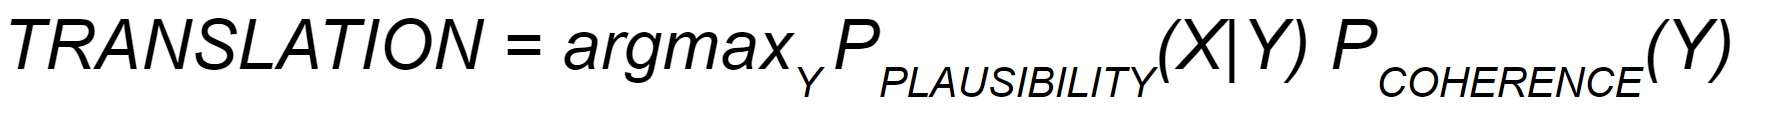
Вариантов перевода много => ищем наиболее вероятный

### Моделирование вероятности

**Допущение**: *x* можно преобразовать в любое предложение *y*, при этом некоторые варианты *y* будут более правдоподобными

***P(y)*** - **априорная** вероятность; вероятность того, что y может произойти, допустим. По теореме Байеса, это вероятность встречи y до учета экспериментальных знаний (наши фоновые знания). По Koehn

***P(x|y)*** - **условная** вероятность; вероятность возникновения *y* после или при наличии *x* => вероятность *y*, когда x уже произошло => вероятность того, что *у* соответствует *x* в параллельном корпусе

###The Noisy Channel

**Задача**: передача аудиосигнала (например, по телефону), моделирование источника и канала

**Проблема**: мы передаем некий сигнал *x*, помехи телесети превращают его в *y*

**Представляем, что *y* – искаженная версия x**

Как **восстановить** *x* по данным *y*?
* Обозреть все возможные *y*
* Понять, какому *y* может соответствовать *x*
* Выбрать наиболее правдоподобное соответствие


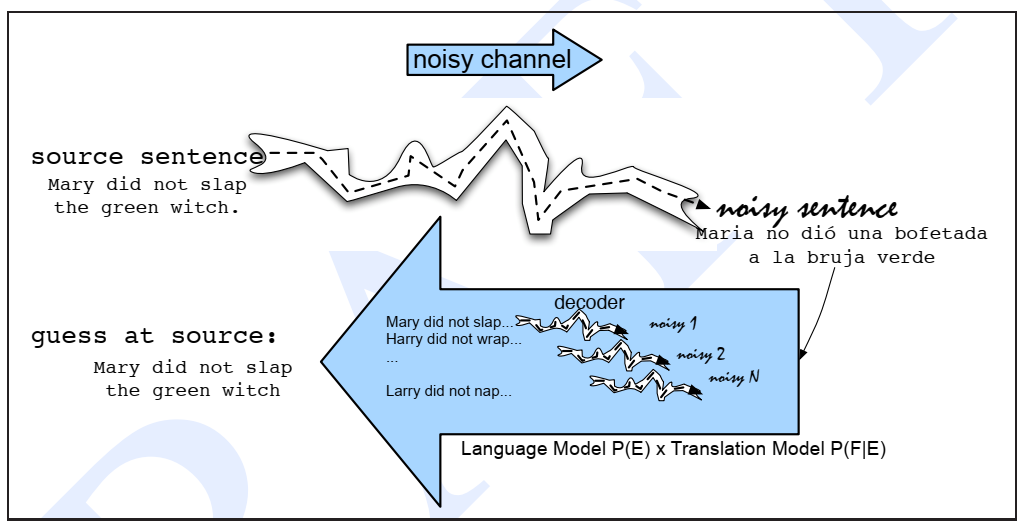

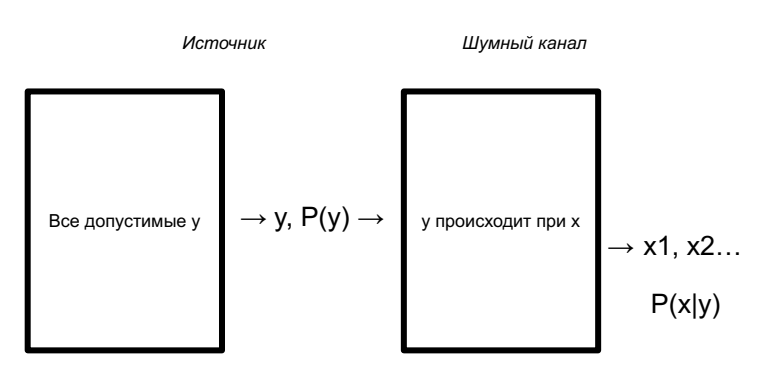

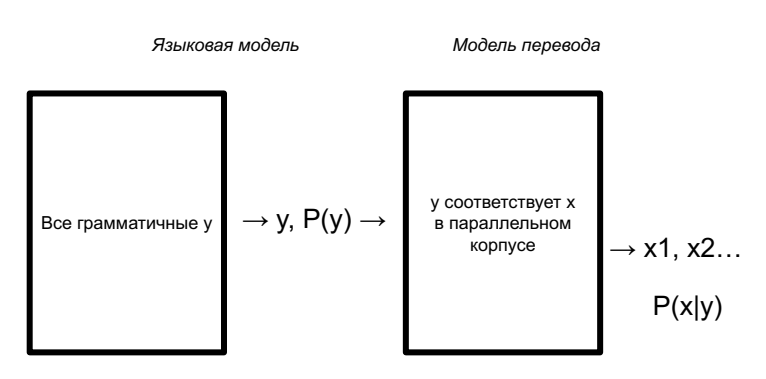

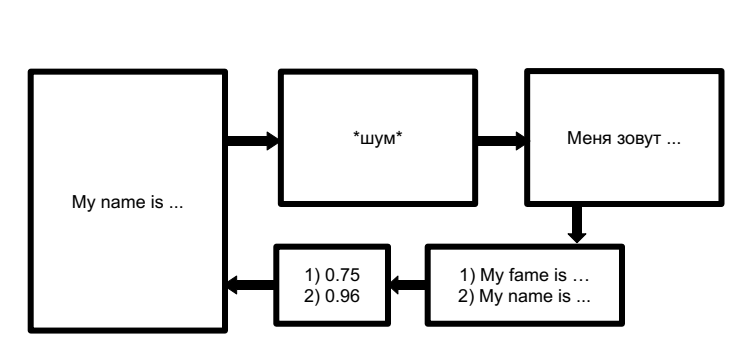

## SMT как задача ML

* Создаем **вероятностное распределение** соответствий *x* - *y*
* Распределение – результат машинного обучения
* Мы будем использовать его для перевода текстов, **не зафиксированных** в обучающем корпусе
* Для этого картируем распределение на *x*
* По сути, мы ищем **правила** преобразования *x* в *y* путем автовосстановления *x* из *y*


**Как считать?** - собираем статистику (*слово - частотность*)

**Результат**: оценка максимального правдоподобия (*y = Hause... при x = house с вероятностью 0,79*)

### Компоненты SMT

* Статистическая языковая модель P(Y)(одноязычная) → связность
* Статистическая модель перевода P(X|Y)(двуязычная) → правдоподобие
* Модель-декодер для преобразования X в Y


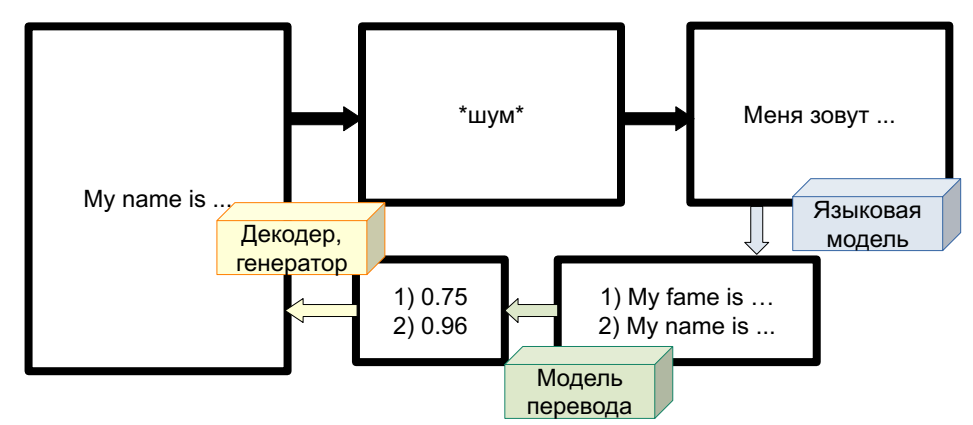

#### Языковая модель

***N-граммная языковая модель***

**Мотивация**: предсказать следующее слово

по Koehn & Callison-Burch:
* следит за соблюдением правильного порядка слов
* включает некоторое представление о грамматичности
* как правило, используется триграммная языковая модель
* расчеты могут производиться с помощью статистической грамматики (напр. PCFG)


**Формальное определение**

Смоделировать вероятностное распределение для корпуса текстов

Дано: последовательность токенов *x_1*, *x_2* … *x_t-1*

Предсказать вероятностное распределение вероятностей для токена *x*ₜ, который может быть любым токеном из словаря *V = {w_1 … w_|V|}*

*P(xₜ|xₜ … x_1)*


**Марковское свойство**

Распределение вероятностей будущих состояний процесса зависит от текущего состояния, а не от предшествующих ему

*P(future|present, past) = P(future|present)*

*P(N|N-1 … 1) = P(N|N-1)*


**Для всего корпуса**

Взаимосвязь совместной вероятности и условной вероятности:
* считаем совместную для корпуса
* считаем условную для N-грамм, которые его составляют


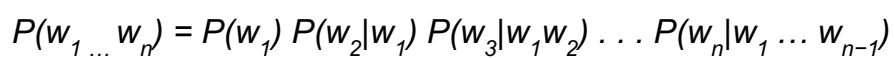

#### Модель перевода

**T-tables**

Результат перевода: слово y и его условная вероятность *t(x|y)*

Такой тип вероятностного распределения будем называть *translation / distortion probability*


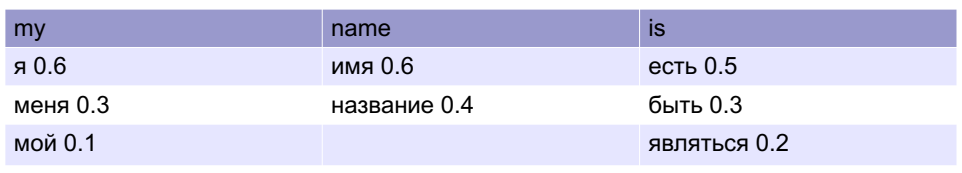

**Выравнивание**
* Вводим скрытую переменную а (alignment)
P(x|y) = P(x, a|y)
* Выравнивание – соответстветствие между x и y на уровне слов или фраз
* Вызов: типологические различия языков


**Вектор a**

Картирование x на y производится по формуле *a : x → y*

Результат картирования (mapping):

a : {1 → 1, 2 → 2, 3 → 2, 4 → 3}


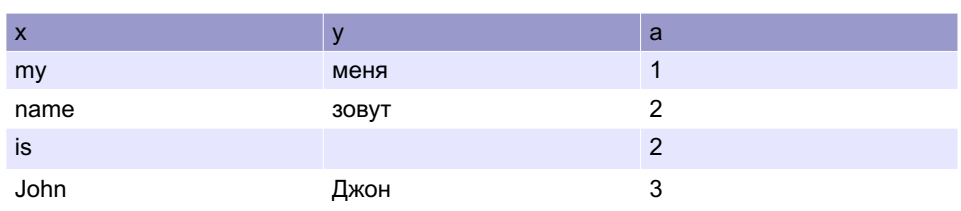

Избегаем синтаксические трудности с помощью пустышек **NULL**:
мы хотим, чтобы матрицы были одного размера!

a : {1 → 1, 2 → 2, 3 → 3, 4 → 4}


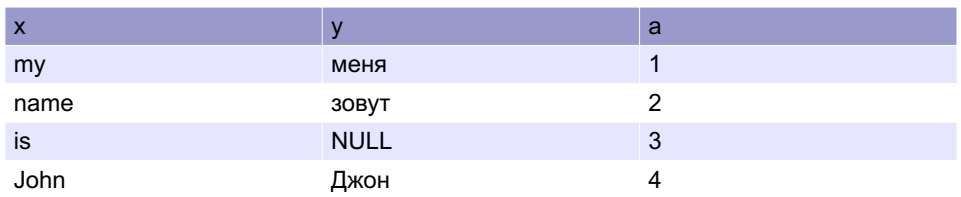

**IBM Alignment**

5 моделей для статистического моделирования выравнивания и перевода

Несколько уровней сложности:
* Лексический анализ
* Позиционное кодирование
* Fertility / spurious words


**IBM 1**
* Несколько вариантов перевода
* Отказ от моделирования предложений в пользу моделирования слов или фраз
* Генеративный подход: разбиваем работу на части, моделируем пошагово и соединяем в связный текст
* Только лексика
* *P(x, a|y) = t(меня|my) t(зовут|name) t(NULL|is)*




1.   Создаем заготовку длины len(x)
```
[my] [name] [is] [John]
```
2.   Выводим вектор для выравнивания
```
[1] [2] [3] [4]
```
3.   Генерируем перевод путем сопоставления с обученным представлением
```
[меня] [зовут] [NULL] [Джон]
```


**Expectation-Maximization**
* Алгоритм для поиска скрытых переменных
* E: генерируем некое допущение (случайные величины или нормальное распределение)
* M: максимизируем правдоподобие, обучаем модель так, чтобы оптимизировать E


#### Декодер

**Как найти лучший перевод?**
* Все варианты перевода – наши гипотезы
* “Перебор” каждой гипотезы – это дорого!
* Эвристика: первое совпадение будем считать лучшим (жадный алгоритм)
* **Beam Search**: поиск по графу

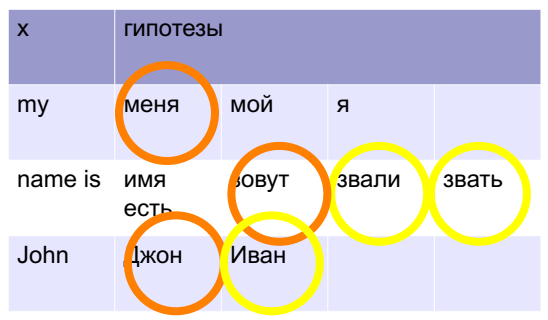